# Using autoencoder (AE) for unsupervised feature learning

In this notebook we will train different flavors of autoencoders (fcAC, denoising fcAE, convAE, denoising convAE) on 10k MNIST images. Then we will push 2.5k images through the trained AE and extracht the "bottleneck"-layer activation and use them as a unsupervised learned feature representation of the respective image. 

The keras code was inspired by https://blog.keras.io/building-autoencoders-in-keras.html 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Loading the MNIST dataset

In [2]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


For the fcAC we first flatten the data and normalize it to the 0-1 intervall.

In [12]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


To speed up computation, we dont use the whole dataset (10k train and 2.5k test)

In [13]:
x_train=x_train[0:10000]
x_test=x_test[0:2500]
print(x_train.shape)
print(x_test.shape)

(10000, 784)
(2500, 784)


In [5]:
import keras
from keras.models import Sequential
from keras.layers import Input,Activation, Dense, Conv2D, MaxPooling2D, UpSampling2D

## 1) fc AE
We use a fc NN with a bottleneck architecture and the objective to reconstruct the input image.

In [6]:
name = 'fc_autoencoder'

model = Sequential()
model.add(Dense(32, input_dim=(784),activation='relu',name="bottleneck"))
model.add(Dense(784,activation='sigmoid',name="reconstruction"))

model.compile(loss='binary_crossentropy',
              optimizer='adadelta')

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bottleneck (Dense)           (None, 32)                25120     
_________________________________________________________________
reconstruction (Dense)       (None, 784)               25872     
Total params: 50,992.0
Trainable params: 50,992
Non-trainable params: 0.0
_________________________________________________________________


In [8]:
# the target is to reconstruct the input, therefore we set x and y to x_train
model.fit(x=x_train, y=x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),verbose=2)

Train on 10000 samples, validate on 2500 samples
Epoch 1/100
1s - loss: 0.6605 - val_loss: 0.5679
Epoch 2/100
1s - loss: 0.4110 - val_loss: 0.3164
Epoch 3/100
1s - loss: 0.2983 - val_loss: 0.2846
Epoch 4/100
1s - loss: 0.2838 - val_loss: 0.2761
Epoch 5/100
1s - loss: 0.2786 - val_loss: 0.2718
Epoch 6/100
1s - loss: 0.2754 - val_loss: 0.2695
Epoch 7/100
1s - loss: 0.2730 - val_loss: 0.2661
Epoch 8/100
1s - loss: 0.2706 - val_loss: 0.2643
Epoch 9/100
1s - loss: 0.2682 - val_loss: 0.2625
Epoch 10/100
1s - loss: 0.2656 - val_loss: 0.2595
Epoch 11/100
1s - loss: 0.2626 - val_loss: 0.2564
Epoch 12/100
1s - loss: 0.2592 - val_loss: 0.2534
Epoch 13/100
1s - loss: 0.2556 - val_loss: 0.2497
Epoch 14/100
1s - loss: 0.2517 - val_loss: 0.2466
Epoch 15/100
1s - loss: 0.2478 - val_loss: 0.2431
Epoch 16/100
1s - loss: 0.2440 - val_loss: 0.2398
Epoch 17/100
1s - loss: 0.2403 - val_loss: 0.2362
Epoch 18/100
1s - loss: 0.2368 - val_loss: 0.2327
Epoch 19/100
1s - loss: 0.2334 - val_loss: 0.2299
Epoch 20/1

Extracting the bottleneck features and predicting the reconstruction

In [9]:
from keras.models import Model
model_bottleneck = Model(inputs=model.input, outputs=model.get_layer('bottleneck').output)

In [10]:
representation=model_bottleneck.predict(x_test)

In [11]:
#np.savez("fc_autoencoder_MNIST",representation,y_test)

Now we want to get the target of the AE - meaning the reconstructed image.

In [12]:
reconstruction=model.predict(x_test)

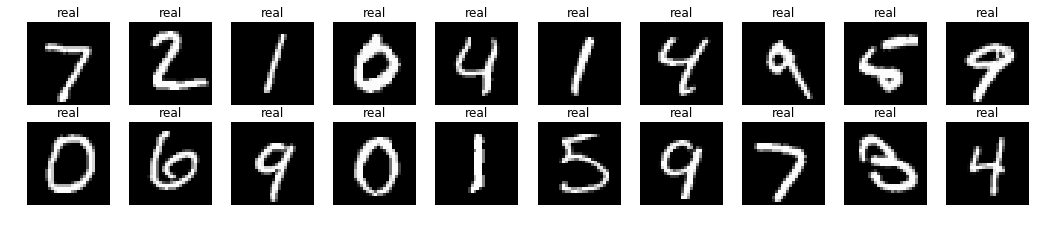

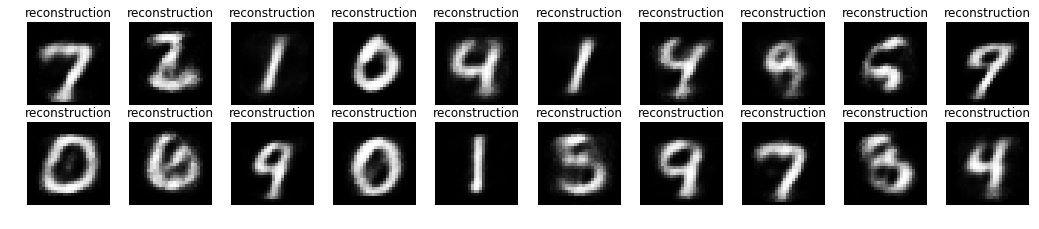

In [13]:
plt.figure(figsize=(18,18))
for i in range(0,20):
    plt.subplot(10,10,(i+1))
    plt.imshow(np.squeeze(x_test[i].reshape(28,28,1)),cmap="gray")
    plt.axis('off')
    plt.title('real')
    
plt.figure(figsize=(18,18))
for i in range(0,20):
    plt.subplot(10,10,(i+1))
    plt.imshow(np.squeeze(reconstruction[i].reshape(28,28,1)),cmap="gray")   
    plt.axis('off')
    plt.title('reconstruction')

###  How good are the unsupervised learned features of the fcAE? 
One way to assess the quality of the bottleneck features is to assess if these features can help us to reveal the 10 different patterns (digits) in the dataset in a 2D t-SNE. The input to the t-SNE are the extracted bottleneck-feature-representation of the 2500 test images and color the points correspondsto the labels (which were not used so far). 

In [14]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
tsne = model.fit_transform(representation) 

In [16]:
y_test=y_test[0:2500]

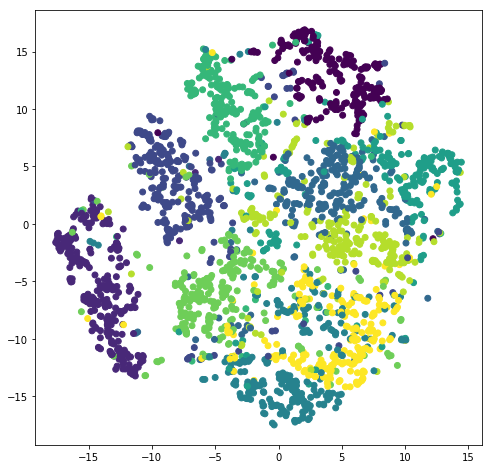

In [17]:
plt.figure(figsize=(8,8))
plt.scatter(x=tsne[:,0],y=tsne[:,1],c=y_test,s=35)

## 2) denoising fc AE
Now we will use the same network architecture but we have slightly different objective since we do not ask to reconstruct the input but a denoised version of the input. For the denoising AE we will add noise to the original data and train on the task to reconstruct the denoised image. 

In [17]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [18]:
name = 'fc_autoencoder_denoising'

model = Sequential()
model.add(Dense(32, input_dim=(784),activation='relu',name="bottleneck"))
model.add(Dense(784,activation='sigmoid',name="reconstruction"))

model.compile(loss='binary_crossentropy',
              optimizer='adadelta')

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bottleneck (Dense)           (None, 32)                25120     
_________________________________________________________________
reconstruction (Dense)       (None, 784)               25872     
Total params: 50,992.0
Trainable params: 50,992
Non-trainable params: 0.0
_________________________________________________________________


In [20]:
model.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),verbose=2)

Train on 10000 samples, validate on 2500 samples
Epoch 1/100
5s - loss: 0.6136 - val_loss: 0.4144
Epoch 2/100
5s - loss: 0.3167 - val_loss: 0.2741
Epoch 3/100
5s - loss: 0.2759 - val_loss: 0.2652
Epoch 4/100
5s - loss: 0.2713 - val_loss: 0.2633
Epoch 5/100
5s - loss: 0.2695 - val_loss: 0.2623
Epoch 6/100
5s - loss: 0.2684 - val_loss: 0.2609
Epoch 7/100
5s - loss: 0.2676 - val_loss: 0.2611
Epoch 8/100
5s - loss: 0.2669 - val_loss: 0.2598
Epoch 9/100
5s - loss: 0.2663 - val_loss: 0.2591
Epoch 10/100
6s - loss: 0.2656 - val_loss: 0.2586
Epoch 11/100
6s - loss: 0.2650 - val_loss: 0.2581
Epoch 12/100
5s - loss: 0.2642 - val_loss: 0.2573
Epoch 13/100
5s - loss: 0.2634 - val_loss: 0.2565
Epoch 14/100
5s - loss: 0.2624 - val_loss: 0.2548
Epoch 15/100
5s - loss: 0.2614 - val_loss: 0.2549
Epoch 16/100
5s - loss: 0.2601 - val_loss: 0.2527
Epoch 17/100
5s - loss: 0.2587 - val_loss: 0.2515
Epoch 18/100
5s - loss: 0.2572 - val_loss: 0.2504
Epoch 19/100
5s - loss: 0.2554 - val_loss: 0.2498
Epoch 20/1

Extracting the bottleneck features and predicting the reconstruction

In [21]:
from keras.models import Model
model_bottleneck = Model(inputs=model.input, outputs=model.get_layer('bottleneck').output)

In [22]:
representation=model_bottleneck.predict(x_test_noisy)

In [23]:
#np.savez("fc_autoencoder_denoising_MNIST",representation,y_test)

In [24]:
reconstruction=model.predict(x_test_noisy)

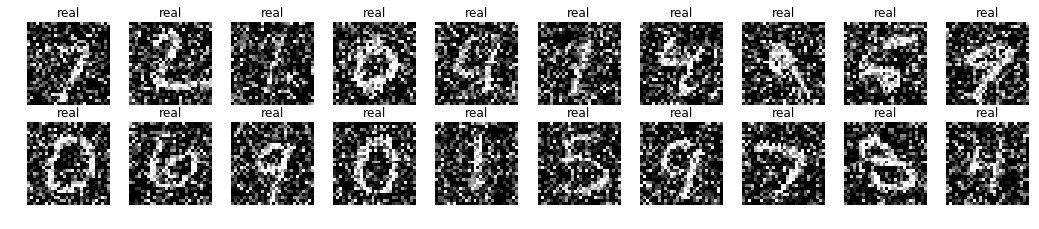

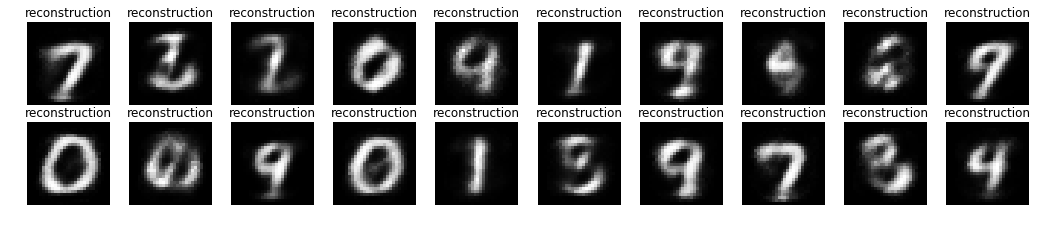

In [25]:
plt.figure(figsize=(18,18))
for i in range(0,20):
    plt.subplot(10,10,(i+1))
    plt.imshow(np.squeeze(x_test_noisy[i].reshape(28,28,1)),cmap="gray")
    plt.axis('off')
    plt.title('real')
    
plt.figure(figsize=(18,18))
for i in range(0,20):
    plt.subplot(10,10,(i+1))
    plt.imshow(np.squeeze(reconstruction[i].reshape(28,28,1)),cmap="gray")   
    plt.axis('off')
    plt.title('reconstruction')

###  How good are the unsupervised learned features of the denoising fcAE? 
The input to the t-SNE are the extracted bottleneck-feature-representation of the 2500 test images and color the points correspondsto the labels (which were not used so far). 


In [26]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
tsne = model.fit_transform(representation) 

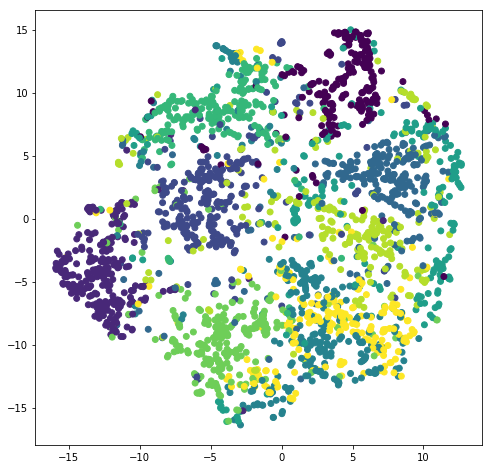

In [27]:
plt.figure(figsize=(8,8))
plt.scatter(x=tsne[:,0],y=tsne[:,1],c=y_test,s=35)

Now lets see how a convolutional autoencoder performs

## 3) convAE 
Now we will use a convolutional AE network architecture with the objective to reconstruct the input.

In [28]:
name = 'cnn_autoencoder'
model = Sequential()

model.add(Conv2D(16, (3,3),activation='relu',padding='same',input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(8, (3,3),activation='relu',padding='same'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(8, (3,3),activation='relu',padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(16, (3,3),activation='relu',padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(1, (3,3),activation='sigmoid',padding='same'))

model.compile(loss='binary_crossentropy',
              optimizer='adadelta')

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 16)        1168      
__________

Reshape the data to (28,28,1) format

In [30]:
x_train=x_train.reshape(len(x_train),28,28,1)
x_test=x_test.reshape(len(x_test),28,28,1)
x_train_noisy=x_train_noisy.reshape(len(x_train_noisy),28,28,1)
x_test_noisy=x_test_noisy.reshape(len(x_test_noisy),28,28,1)

In [31]:
#model.fit(x_train, x_train,
#                epochs=50,
#                batch_size=256,
#                shuffle=True,
#                validation_data=(x_test, x_test),verbose=2)

In [32]:
#model.save('cnn_autoencoder.h5') 

In [33]:
#here we load the already trained network to save time
from keras.models import load_model
model = load_model('../data/models/cnn_autoencoder.h5')

Extracting the bottleneck features and predicting the reconstruction

In [34]:
from keras.models import Model
model_bottleneck = Model(inputs=model.input, outputs=model.get_layer('conv2d_3').output)

In [35]:
representation=model_bottleneck.predict(x_test)

In [36]:
representation.shape

(2500, 7, 7, 8)

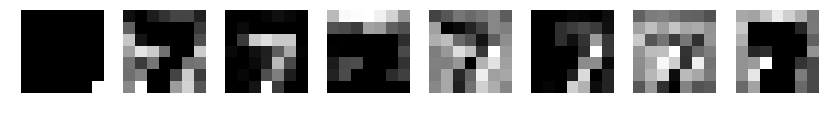

In [37]:
plt.figure(figsize=(18,18))
for i in range(0,8):
    plt.subplot(10,10,(i+1))
    plt.imshow(np.squeeze(representation[0,:,:,i]),cmap="gray")
    plt.axis('off')

In [38]:
reconstruction=model.predict(x_test)

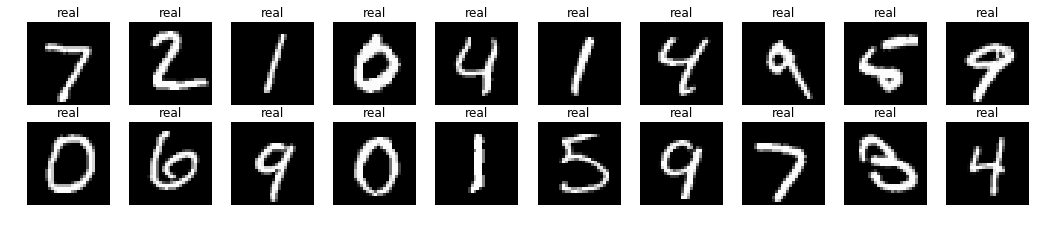

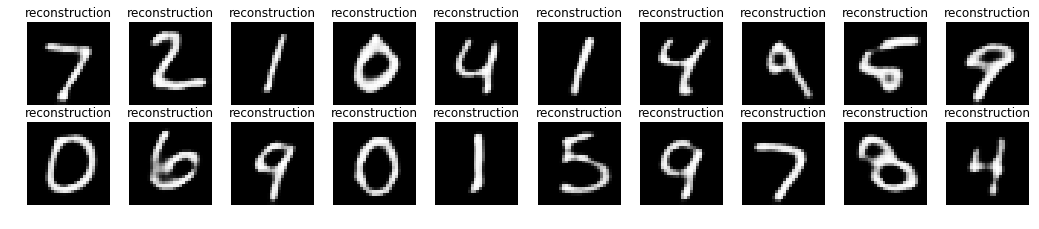

In [39]:
plt.figure(figsize=(18,18))
for i in range(0,20):
    plt.subplot(10,10,(i+1))
    plt.imshow(np.squeeze(x_test[i]),cmap="gray")
    plt.axis('off')
    plt.title('real')
    
plt.figure(figsize=(18,18))
for i in range(0,20):
    plt.subplot(10,10,(i+1))
    plt.imshow(np.squeeze(reconstruction[i]),cmap="gray")   
    plt.axis('off')
    plt.title('reconstruction')

###  How good are the unsupervised learned features of the convAE? 
The input to the t-SNE are the extracted bottleneck-feature-representation of the 2500 test images and color the points correspondsto the labels (which were not used so far). 

In [40]:
representation=representation.reshape([len(representation),7*7*8])

In [41]:
#np.savez("cnn_autoencoder_MNIST",representation,y_test)

In [42]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
tsne = model.fit_transform(representation) 

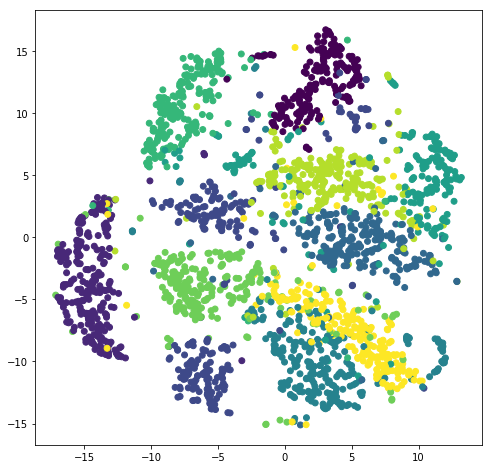

In [43]:
plt.figure(figsize=(8,8))
plt.scatter(x=tsne[:,0],y=tsne[:,1],c=y_test,s=35)

## 4) denoising convAE
Now we will use a denoising convolutional AE network architecture with the objective to reconstruct a denoised image from a noisy input. 

In [44]:
name = 'cnn_autoencoder_denoising'
model = Sequential()

model.add(Conv2D(16,(3,3),activation='relu',padding='same',input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(8,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(8,(3,3),activation='relu',padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(16,(3,3),activation='relu',padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(1,(3,3),activation='sigmoid',padding='same'))

model.compile(loss='binary_crossentropy',
              optimizer='adadelta')

In [45]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 16)        1168      
__________

In [46]:
#model.fit(x_train_noisy, x_train,
#                epochs=50,
#                batch_size=256,
#                shuffle=True,
#                validation_data=(x_test_noisy,x_test ),verbose=2)

Extracting the bottleneck features and predicting the reconstruction

In [47]:
#model.save('cnn_autoencoder_denoising.h5') 

In [48]:
#here we load the already trained network to save time
from keras.models import load_model
model = load_model('../data/models/cnn_autoencoder_denoising.h5')

In [49]:
from keras.models import Model
model_bottleneck = Model(inputs=model.input, outputs=model.get_layer('conv2d_8').output)

In [50]:
representation=model_bottleneck.predict(x_test_noisy)

In [51]:
representation.shape

(2500, 7, 7, 8)

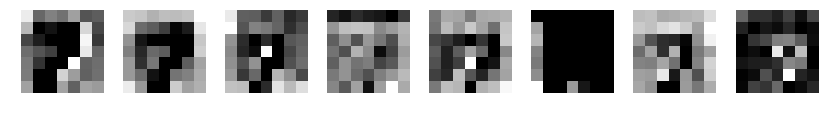

In [52]:
plt.figure(figsize=(18,18))
for i in range(0,8):
    plt.subplot(10,10,(i+1))
    plt.imshow(np.squeeze(representation[0,:,:,i]),cmap="gray")
    plt.axis('off')

In [53]:
reconstruction=model.predict(x_test_noisy)

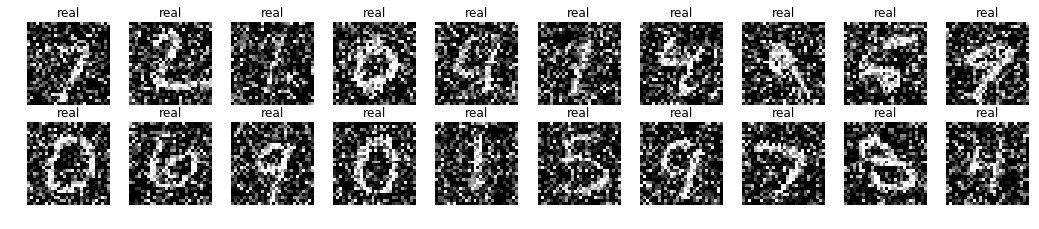

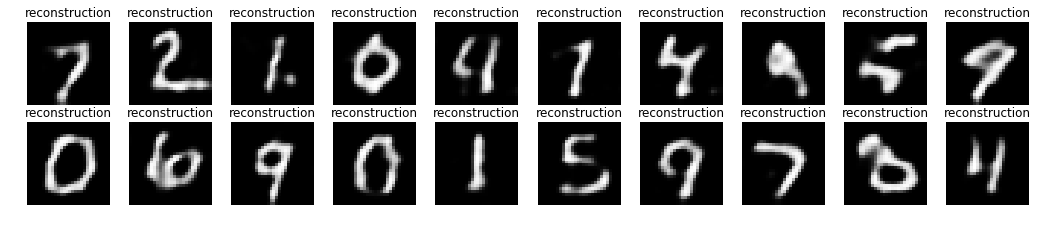

In [54]:
plt.figure(figsize=(18,18))
for i in range(0,20):
    plt.subplot(10,10,(i+1))
    plt.imshow(np.squeeze(x_test_noisy[i]),cmap="gray")
    plt.axis('off')
    plt.title('real')
    
plt.figure(figsize=(18,18))
for i in range(0,20):
    plt.subplot(10,10,(i+1))
    plt.imshow(np.squeeze(reconstruction[i]),cmap="gray")   
    plt.axis('off')
    plt.title('reconstruction')

###  How good are the unsupervised learned features of the denoising convAE? 
The input to the t-SNE are the extracted bottleneck-feature-representation of the 2500 test images and color the points correspondsto the labels (which were not used so far). 

In [55]:
representation=representation.reshape([len(representation),7*7*8])

In [56]:
#np.savez("cnn_autoencoder_denoiseing_MNIST",representation,y_test)

In [57]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
tsne = model.fit_transform(representation) 

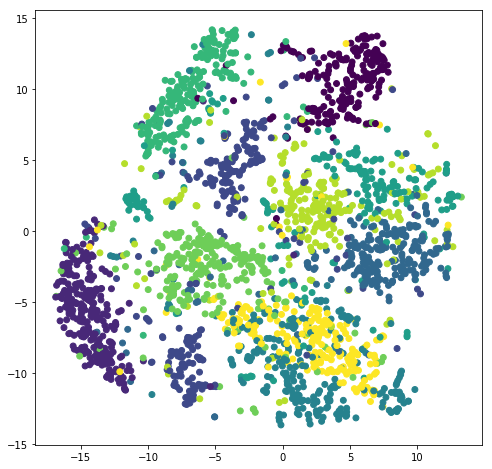

In [58]:
plt.figure(figsize=(8,8))
plt.scatter(x=tsne[:,0],y=tsne[:,1],c=y_test,s=35)

## Use imageNet trained VGG16 to provide unsupervised features for MNIST
Since loading the trained VGG16 and pushing 2.5k MNIST data through to extract the features from the fcL1 layer takes quite some time, we have done this beforehand and saved the features in a file. Here, we load the extracted vgg16 features of the 2.5k MNIST testdata und do a 2D visualization of the representation layer with the corresponding labels

In [6]:
import urllib
import os
if not os.path.isfile('vgg16_fcl1_MNIST.npz'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/207krpgbyo7hc9u/vgg16_fcl1_MNIST.npz?dl=1",
    "vgg16_fcl1_MNIST.npz")
%ls -hl vgg16_fcl1_MNIST.npz

-rw-r--r-- 1 root root 79M Apr  3 15:22 vgg16_fcl1_MNIST.npz


In [7]:
Data=np.load("vgg16_fcl1_MNIST.npz")
print(Data.files)
representation = Data["arr_0"]
y_test = Data["arr_1"]
representation.shape

['arr_1', 'arr_0']


(2500, 4096)

In [8]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
tsne = model.fit_transform(representation) 

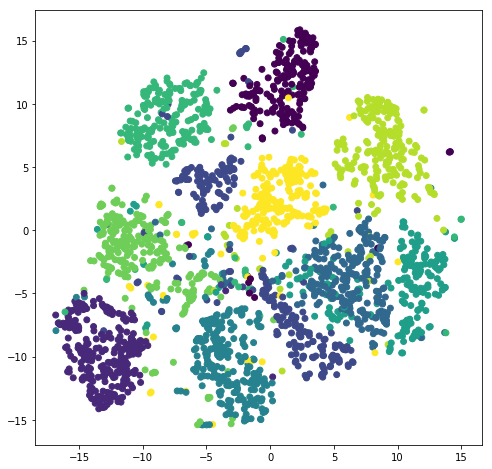

In [9]:
plt.figure(figsize=(8,8))
plt.scatter(x=tsne[:,0],y=tsne[:,1],c=y_test,s=35)